Lets start with a simple crawl and work our way up to a complex agent.

Lets start a project that begins with a simple llm use case that builds on itself and concludes with an AI agent that includes tools, RAG, and fine-tuning with custom decoder transformer.

In [63]:
import os
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from typing_extensions import TypedDict
from langchain_tavily import TavilySearch
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# LLM

The main workhorse of our REACT agent. This is the brains of our operations. However it is only as good as the data it has been pretrained on.

In [64]:
os.environ.get("OPENAI_API_KEY")
os.environ.get("TAVILY_API_KEY") # API search engine tool

llm = init_chat_model(
    model = "gpt-4o-mini",
    model_provider="openai",
    temperature=0,
    max_tokens = 50
)

llm.invoke("hello").content

'Hello! How can I assist you today?'

One quick way to demonstrate this is by asking what the weather is.

In [65]:
llm.invoke("what is the weather in New York?").content

"I don't have real-time data access to provide current weather information. To find the latest weather in New York, I recommend checking a reliable weather website or app."

# Tools

The fun part is giving the llm the ability to use tools. This is helpful for very domain specific task such as using proprietary data or applications. Lets answer our weather question and maybe a simple math problem using tools.

In [66]:
# tool used to search the web - useful for getting the latest information or data that the model may not have been trained
web_search_tool = TavilySearch(max_results=2)

In [67]:
# second tool is based on our own simple math function used to return the remainder of a division operation

def remainder(a: int, b: int) -> int:
    """returns the remainder of  a divided by b.

    Args:
        a: first int
        b: second int
    """
    return a % b

Lets bind these tools to our llm.

In [68]:
tools = [web_search_tool, remainder]

llm_with_tools = llm.bind_tools(tools)

# Langraph

Our goal is to create a chain of events using Langraph as our framework. Each of the steps in our chain is represented by a node. So we will wrap our llm as a function.

In [69]:
# System message | prompt engineering - assigning a role to the llm
sys_msg = SystemMessage(content="You are a helpful assistant that can use tools to answer questions. You can search the web and perform simple math operations. Use the tools when necessary.")

# Node - REACT agent
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

An important note about MessageState. As you move from node to node our state gets truncated, or think of it as our new data returned over-rides existing data. This data is traditionally a strict dictionary that stores messages in a dictionary. Such as the one below. To instead append data we use MessageState with a built-in default key of message and also a function called add_message, also referred to as a reducer, to append messages as we move from node to node. Note these messages are usually our conversation between AI and human. This state is also referred to as a schema, because it is a strict dictionary used to enforce data types for our messages as we move form node to node.

In [70]:

state = {"graph_state": ""}

# example below is 'similar'

class State(TypedDict): # dictionary object with specific keys and types
    graph_state: str

Lets create our graph using Stategraph, edges and nodes are incorporated to our new object.

In [71]:
builder = StateGraph(MessagesState)

Define the nodes. 

In [72]:
# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

Lets add edges to connect these nodes.

In [73]:
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",  tools_condition)
builder.add_edge("tools", "assistant") # this edge connects the tools node back to the assistant node to return the results of the tool invocation in natural language format

Before we invoke our agent, lets give it some memory so it retains messages across graph executions.

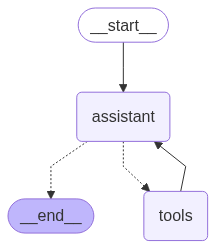

In [74]:
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# Specify a thread, is it is used to keep track of the conversation history
config = {"configurable": {"thread_id": "1"}}

# Show
display(Image(react_graph_memory.get_graph(xray=True).draw_mermaid_png()))

Now lets invoke our agent with a simple question and see how it works.

In [76]:
# Specify an input
messages = [HumanMessage(content="What is the remainder of 10 divided by 3 and what is the weather in Dallas, TX?")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the remainder of 10 divided by 3 and what is the weather in New York?
================================== Ai Message ==================================
Tool Calls:
  remainder (call_p4OO1NHaeOuoLtXruRQO60Lo)
 Call ID: call_p4OO1NHaeOuoLtXruRQO60Lo
  Args:
    a: 10
    b: 3
  tavily_search (call_jQJ6eVJNFTcPvPzZPV1BjSAA)
 Call ID: call_jQJ6eVJNFTcPvPzZPV1BjSAA
  Args:
    query: current weather in
================================= Tool Message =================================
Name: remainder

1
================================= Tool Message =================================
Name: tavily_search

{"query": "current weather in", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in [location]", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': \"Modjadje's Location\", 'region': 'Limpopo', 'country': 'South Africa', 'lat': -23.6167, 'lon': 3